In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os,shutil
import PIL
import re
import random 
from PIL import ImageOps, ImageFilter
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import lightgbm as lgb
from catboost import CatBoostClassifier
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import zipfile

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14348447161221154759
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15685569792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16982256618620689746
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
DATA_DIR = '/kaggle/input/tabular-playground-series-apr-2021/'
df_train = pd.read_csv(DATA_DIR + 'train.csv')
df_test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# EDA

Колонки данных: 
- PassengerId: Id пассажира 
- Survived: Жив\Мертв
- Pclass: Класс пасажира
    * 1st = Высший 
    + 2nd = Средний
    - 3rd = Низкий
- Name: Имя пассажира 
- Sex: Пол
- Age: Возраст
- SibSp: братьях и сестрах / супругах на борту
    * Sibling = brother, sister, stepbrother, stepsister
    + Spouse = husband, wife (mistresses and fiancés were ignored)
- Parch: родители\ дети на борту 
    * Parent = mother, father
    + Child = daughter, son, stepdaughter, stepson
    - Некоторые дети путешествуют с нянями, поэтому parch=0 
- Ticket: Билет
- Fare:
- Cabin: Номер\Кабина
- Embarked: Порт посадки 

### ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет

In [5]:
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
df_test['Survived'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Pclass       200000 non-null  int64  
 2   Name         200000 non-null  object 
 3   Sex          200000 non-null  object 
 4   Age          193221 non-null  float64
 5   SibSp        200000 non-null  int64  
 6   Parch        200000 non-null  int64  
 7   Ticket       190196 non-null  object 
 8   Fare         199733 non-null  float64
 9   Cabin        61303 non-null   object 
 10  Embarked     199473 non-null  object 
 11  sample       200000 non-null  int64  
 12  Survived     200000 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 19.8+ MB


### Посчитаем количество пустых строк для каждого столбца в дасасете

In [7]:
NaN_Sum = lambda col: col.isnull().sum()  # Функция для определения количества нулевых знчений  
columns = list(data.columns)
for col in columns:
    print("Количество пустых значений", col, NaN_Sum(data[col]), sep=' ')

Количество пустых значений PassengerId 0
Количество пустых значений Pclass 0
Количество пустых значений Name 0
Количество пустых значений Sex 0
Количество пустых значений Age 6779
Количество пустых значений SibSp 0
Количество пустых значений Parch 0
Количество пустых значений Ticket 9804
Количество пустых значений Fare 267
Количество пустых значений Cabin 138697
Количество пустых значений Embarked 527
Количество пустых значений sample 0
Количество пустых значений Survived 0


## Скопируем исхоный датасет и будем работаь уже с ним, попробуем исследовать каждый столбец, найдем зависимости между стобцами и решим, что делать с каждым из них 

In [8]:
df=data.copy()

## Ticket
- Вытащим из билетов буквенные обазначения 
- Билеты которые имеют только момера обозначим как r
- Пустые билеты заменим на 0 (пока что )

In [9]:
def ticket_label(tickets):
    try:    
        patern = re.compile('\D+')
        tic = (patern.findall(tickets.Ticket)[0])
        return tic.rstrip()
    except IndexError:
        return 'r'
    except TypeError:
        return 'X'

df['Ticket']=df.apply(lambda df: ticket_label(df),axis=1)

In [10]:
df.Ticket.unique()

array(['r', 'X', 'PC', 'C.A.', 'A/', 'A.', 'PP', 'SC/AH', 'SC/PARIS',
       'SC/A', 'C', 'F.C.C.', 'W./C.', 'SOTON/O.Q.', 'A', 'S.O.C.',
       'S.O./P.P.', 'STON/O', 'SOTON/O', 'SOTON/OQ', 'W.E.P.', 'A./',
       'S.C./PARIS', 'CA.', 'F.C.', 'LP', 'SC/A.', 'AQ/', 'SC', 'S.O.P.',
       'WE/P', 'C.A./SOTON', 'S.C./A.', 'P/PP', 'CA', 'SW/PP', 'SC/Paris',
       'STON/OQ.', 'A/S', 'SCO/W', 'S.W./PP', 'S.P.', 'W/C', 'SO/C', 'Fa'],
      dtype=object)

<AxesSubplot:title={'center':'Распределение пассажиров по билетам в зависимости от класса'}, xlabel='Ticket', ylabel='count'>

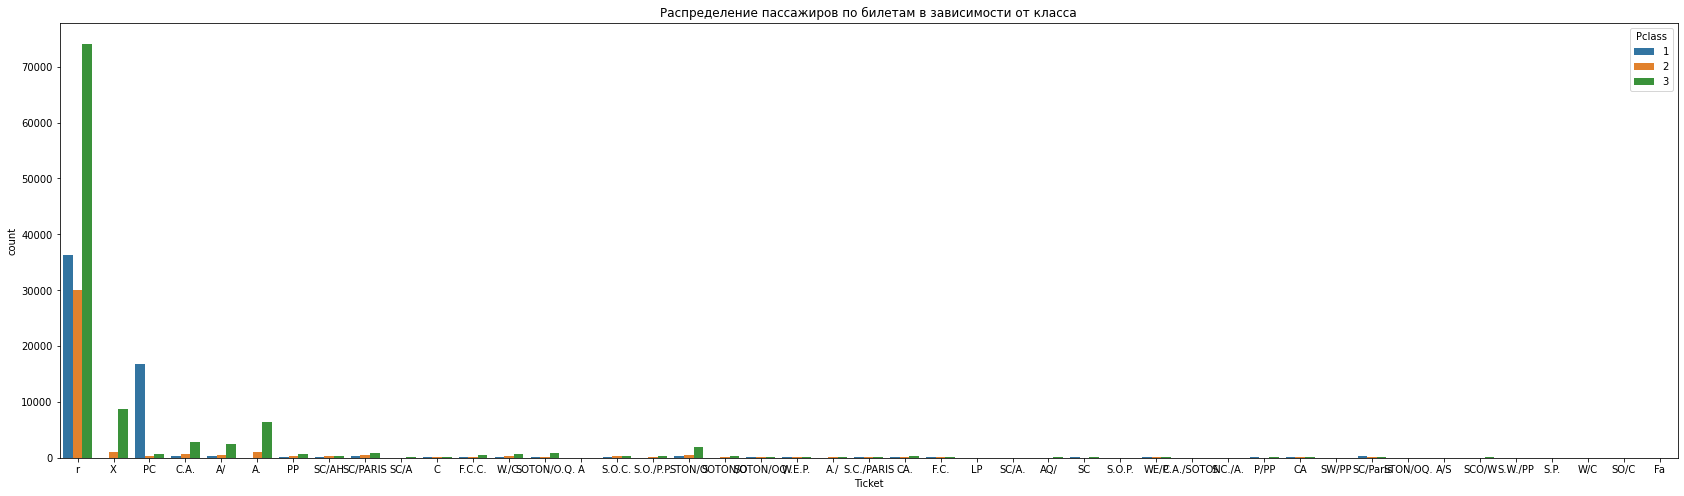

In [11]:
fig, ax = plt.subplots(figsize=(29,8))
plt.title('Распределение пассажиров по билетам в зависимости от класса')
sns.countplot(x="Ticket", hue="Pclass", data=df)

## Parch & SibSp

In [12]:
# Суммируем количества членов семьи на борту 
df['FamOnBoard'] = df['Parch']+df['SibSp']

In [13]:
# Создадим столбец для тех кто плывет один 
df['Alone'] = 1

def alone_on_board(dat):
    if dat.SibSp+dat.Parch==0:
        return 1
    else:
        return 0 
    
df['Alone'] = df.apply(lambda df: alone_on_board(df),axis=1)

## Pclass & Cabin
- Количество пустых строк в Cabin: 138697, Pclass: 0 

In [14]:
print('Общее количество пассажиров первого класса: %s'%len(df[df.Pclass==1].Cabin))
print('Количество пассажиров первого класса не имеющих данных о номере кабины: %s'%df[df.Pclass==1].Cabin.isnull().sum())
print('------------------------------------------------------------')
print('Общее количество пассажиров второго класса: %s'%len(df[df.Pclass==2].Cabin))
print('Количество пассажиров второго класса не имеющих данных о номере кабины: %s'%df[df.Pclass==2].Cabin.isnull().sum())
print('------------------------------------------------------------')
print('Общее количество пассажиров третьего класса: %s'%len(df[df.Pclass==3].Cabin))
print('Количество пассажиров третьего класса не имеющих данных о номере кабины: %s'%df[df.Pclass==3].Cabin.isnull().sum())

Общее количество пассажиров первого класса: 57258
Количество пассажиров первого класса не имеющих данных о номере кабины: 7936
------------------------------------------------------------
Общее количество пассажиров второго класса: 37900
Количество пассажиров второго класса не имеющих данных о номере кабины: 32619
------------------------------------------------------------
Общее количество пассажиров третьего класса: 104842
Количество пассажиров третьего класса не имеющих данных о номере кабины: 98142


### Напишем функцию которая вытащит из номера кабины её тип (ряд)

In [15]:
def cabin_type(cabin):
    try:
        pattern_cabin=re.compile('\w')
        name=str((pattern_cabin.findall(cabin.Cabin))[0])
        return name
    except:
        np.nan

df['Cabin']=df.apply(lambda df: cabin_type(df),axis=1)

#### Оценим уровень выживаемости в зависимости от каюты, а также класс пассажира и закрепленная за ним тип каюты 

<AxesSubplot:title={'center':'Распределение пассажиров по кабинам в зависимости от класса'}, xlabel='Cabin', ylabel='count'>

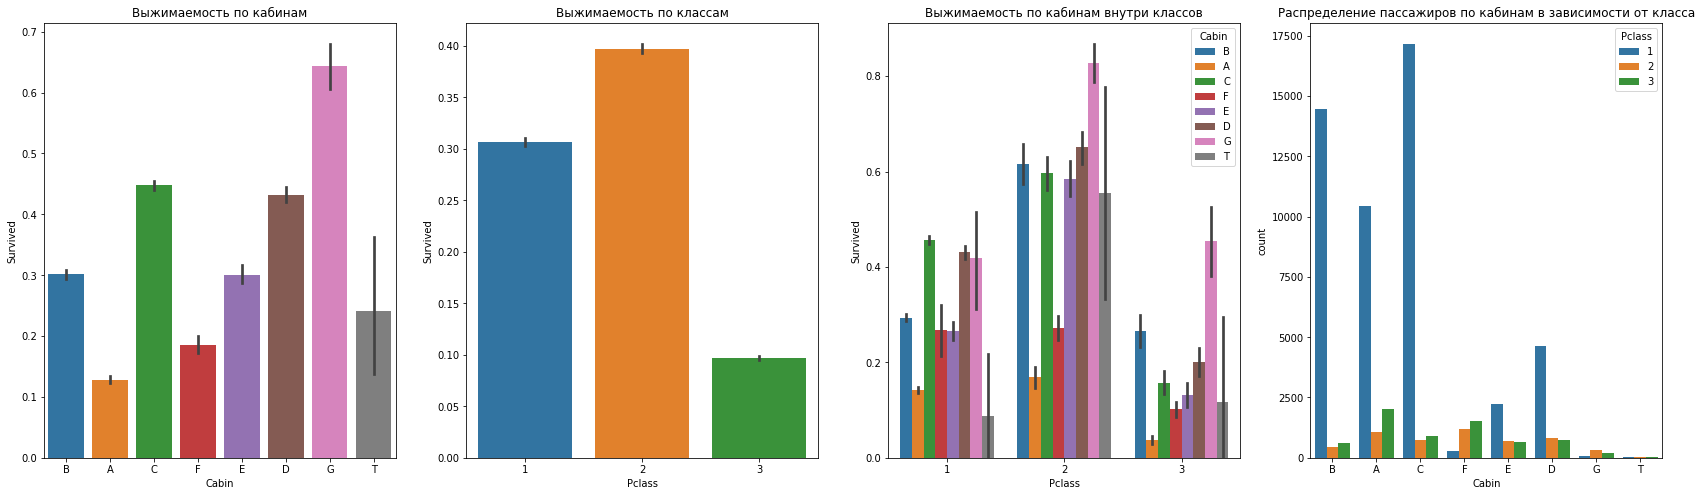

In [16]:
fig, ax = plt.subplots(figsize=(29,8))
plt.subplot(1, 4, 1)
plt.title('Выжимаемость по кабинам')
sns.barplot(data=df, x="Cabin", y="Survived")
plt.subplot(1, 4, 2)
plt.title('Выжимаемость по классам')
sns.barplot(data=df, x="Pclass", y="Survived")
plt.subplot(1, 4, 3)
plt.title('Выжимаемость по кабинам внутри классов')
sns.barplot(x = "Pclass", y = "Survived", hue = "Cabin", data = df)
plt.subplot(1, 4, 4)
plt.title('Распределение пассажиров по кабинам в зависимости от класса')
sns.countplot(x="Cabin", hue="Pclass", data=df)

### Построим график в котором в процентах покажем распределение между кабинами в зависимости от класса

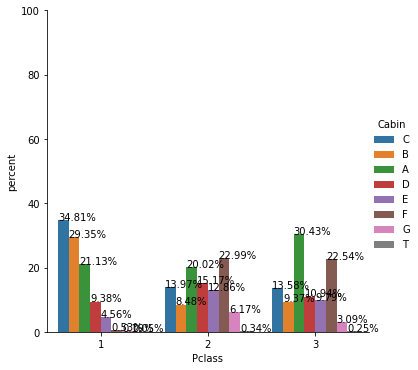

In [17]:
x,y = 'Pclass', 'Cabin'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()


g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### На основании этих графиков можно сказать:
- Пассажиры 1 класса занимали кабины A,B,C,D,E
- Пассажиры 2 класса занимали кабины F,A,D,C,E,G
- Пассажиры 3 класса занимали кабины A,F,C,D,B,G

### Теперь на основании эти данных заменим пустые значения кабины с помощью данных о классе пассажира c привязкой к вероятности 

In [18]:
df.Cabin=df.Cabin.fillna(0)

def cabin_zero(dat):
    cab=0
    class_ = ['C','B','A','D','E','F','G','T']
    if dat.Cabin == 0: 
        if dat.Pclass == 1:
            cab = random.choices(class_,weights=[0.3481, 0.2935, 0.2113,0.0938,0.0456,0.0058,0.0001,0.0018])
        elif dat.Pclass == 2:
            cab = random.choices(class_,weights=[0.1397,0.0848,0.2002,0.1517,0.1286,0.2299,0.0617,0.0034])
        else:
            cab = random.choices(class_,weights=[0.1358,0.0937,0.3043,0.1094,0.0979,0.2254,0.0309,0.0026])
        return cab[0]
    else:
        return dat.Cabin

df['Cabin']=df.apply(lambda df: cabin_zero(df),axis=1)

Построим гарфик распределения еще раз и убедимся, что пропорции остались верными 

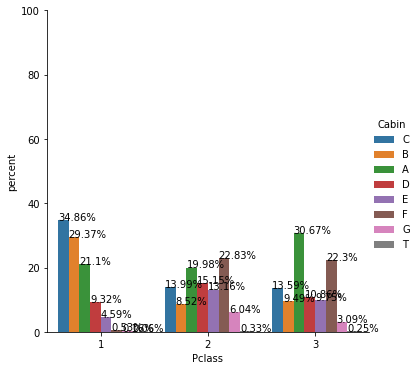

In [19]:
x,y = 'Pclass', 'Cabin'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()


g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## Embarked 
Найдем зависимость между классом пассажира и метом посадки и заменим пропущенные значения 

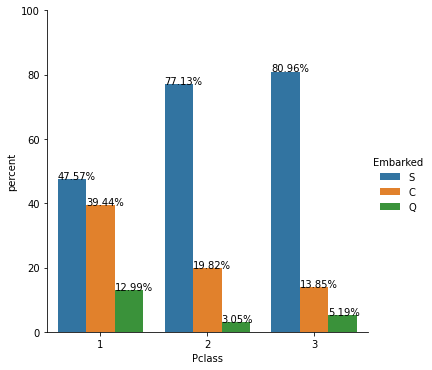

In [20]:
x,y = 'Pclass', 'Embarked'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()


g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [21]:
df.Embarked=df.Embarked.fillna(0)

def embarked_zero(dat):
    embark=0
    port_ = ['S','C','Q']
    if dat.Embarked == 0: 
        if dat.Pclass == 1:
            embark = random.choices(port_,weights=[0.4757,0.3944,0.1299])
        elif dat.Pclass == 2:
            embark = random.choices(port_,weights=[0.7712,0.1982,0.0305])
        else:
            embark = random.choices(port_,weights=[0.80,0.1385,0.0519])
        return embark[0]
    else:
        return dat.Embarked

df['Embarked']=df.apply(lambda df: embarked_zero(df),axis=1)

## Fare 
Пропущенных значений очень мало поэтому заменим неизвестные на медиану

In [22]:
df.groupby('Pclass').Fare.mean()

Pclass
1    103.307086
2     25.602729
3     19.497302
Name: Fare, dtype: float64

In [23]:
df.Fare=df.Fare.fillna(0)

def fare_zero(dat):
    class_1 = 103.209898
    class_2 = 25.595244
    class_3 = 19.498357
    fare =0
    if dat.Pclass == 1: 
        fare = class_1 + random.randint(0,20)
    elif dat.Pclass == 2: 
        fare = class_2 + random.randint(0,7)
    else:
        fare = class_3 + random.randint(0,4)
    return fare

df['Fare']=df.apply(lambda df: fare_zero(df),axis=1)

In [24]:
df['Fare_Medu'] = df['Fare'].fillna(df.Fare.median())

## Age

Пропущенных значений не так много, но стоит попробывать заменить их по умному 

In [25]:
df.groupby('Pclass').Age.mean()

Pclass
1    40.672757
2    36.855067
3    30.205570
Name: Age, dtype: float64

In [26]:
#df.Age=df.Age.fillna(df.Age.median())
df.Age=df.Age.fillna(0)

def age_zero(dat):
    class_1 = 40.672757
    class_2 = 36.855067
    class_3 = 30.205570
    fare =0
    if dat.Pclass == 1: 
        fare = class_1 + random.randint(0,10)
    elif dat.Pclass == 2: 
        fare = class_2 + random.randint(0,7)
    else:
        fare = class_3 + random.randint(0,4)
    return fare

df['Age']=df.apply(lambda df: age_zero(df),axis=1)

## Name

Создадим два столбца для имени и фамилии, возьмем самые популярные фамилии и имена

In [27]:
df['FirstName'] = 'f'
df['LastName'] = 'l'

def first_name(dat):
    patern_1 = re.compile('[A-Z][a-z]+')
    name = patern_1.findall(dat.Name)
    first = name[1]
    return first

def second_name(dat):
    patern_2 = re.compile('[A-Z][a-z]+')
    name = patern_2.findall(dat.Name)
    last = name[0]
    return last
    
df['FirstName'] = df.apply(lambda df: first_name(df),axis=1)       
df['LastName'] = df.apply(lambda df: second_name(df),axis=1)  

In [28]:
print('Количество уникальных имен: %s'%len(df.FirstName.unique()))
print('Количество уникальных фамилий: %s'%len(df.LastName.unique()))

Количество уникальных имен: 4415
Количество уникальных фамилий: 26470


In [29]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample,Survived,FamOnBoard,Alone,Fare_Medu,FirstName,LastName
0,100000,3,"Holliday, Daniel",male,32.205570,0,0,r,19.498357,D,S,0,0,0,1,19.498357,Daniel,Holliday
1,100001,3,"Nguyen, Lorraine",female,30.205570,0,0,r,23.498357,D,S,0,0,0,1,23.498357,Lorraine,Nguyen
2,100002,1,"Harris, Heather",female,40.672757,0,0,r,108.209898,B,C,0,0,0,1,108.209898,Heather,Harris
3,100003,2,"Larsen, Eric",male,40.855067,0,0,r,30.595244,E,S,0,0,0,1,30.595244,Eric,Larsen
4,100004,1,"Cleary, Sarah",female,50.672757,0,2,r,112.209898,B,C,0,0,2,0,112.209898,Sarah,Cleary


# Подготовка даных для нейронных сетей

In [30]:
df_final = df.copy()

In [31]:
df_final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample,Survived,FamOnBoard,Alone,Fare_Medu,FirstName,LastName
0,100000,3,"Holliday, Daniel",male,32.205570,0,0,r,19.498357,D,S,0,0,0,1,19.498357,Daniel,Holliday
1,100001,3,"Nguyen, Lorraine",female,30.205570,0,0,r,23.498357,D,S,0,0,0,1,23.498357,Lorraine,Nguyen
2,100002,1,"Harris, Heather",female,40.672757,0,0,r,108.209898,B,C,0,0,0,1,108.209898,Heather,Harris
3,100003,2,"Larsen, Eric",male,40.855067,0,0,r,30.595244,E,S,0,0,0,1,30.595244,Eric,Larsen
4,100004,1,"Cleary, Sarah",female,50.672757,0,2,r,112.209898,B,C,0,0,2,0,112.209898,Sarah,Cleary


In [32]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

label_futures = ['LastName',
                 'FirstName',
                 'Name',
                 #'Ticket',
                 #'Sex',
                 #'Cabin',
                 #'Embarked',
                ]
categorical_features = ['Sex',
                        'Cabin',
                        'Embarked',
                        'Pclass',
                        'Alone',
                        'FamOnBoard',
                        'Ticket',
                       ]
numerical_features = ['Age',
                      'Fare',
                      #'Fare_Medu',
                      #'Parch',
                      #'SibSp',
                      #'Pclass',
                     ]

#for column in label:
#    df_final[column] = encoder.fit_transform(df_final[column] )
    
for column in label_futures:
    df_final[column] = encoder.fit_transform(df_final[column] )
    
df_final = pd.get_dummies(
        df_final, columns=categorical_features, dummy_na=False)    
    
# Нормализация данных
for column in numerical_features:
    df_final[column] = scaler.fit_transform(df_final[[column]])[:, 0]    

In [33]:
df_final = df_final.drop(columns=[#'Ticket',
                                  'Fare_Medu',
                                  #'FirstName',
                                  #'LastName'
                                 ],
                         axis=1)
df_final

,PassengerId,Name,Age,SibSp,Parch,Fare,sample,Survived,FirstName,LastName,...,Ticket_SOTON/OQ,Ticket_STON/O,Ticket_STON/OQ.,Ticket_SW/PP,Ticket_W./C.,Ticket_W.E.P.,Ticket_W/C,Ticket_WE/P,Ticket_X,Ticket_r
0,100000,72436,0.097717,0,0,0.000000,0,0,886,10830,...,0,0,0,0,0,0,0,0,0,1
1,100001,113674,0.000000,0,0,0.038569,0,0,2608,17134,...,0,0,0,0,0,0,0,0,0,1
2,100002,66227,0.511413,0,0,0.855368,0,0,1647,9978,...,0,0,0,0,0,0,0,0,0,1
3,100003,88389,0.520321,0,0,0.106998,0,0,1295,13303,...,0,0,0,0,0,0,0,0,0,1
4,100004,29306,1.000000,0,2,0.893937,0,0,3670,4406,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,99995,10491,0.520321,0,0,0.097355,1,1,18,1590,...,0,0,0,0,0,0,0,0,0,0
199996,99996,19029,0.373744,0,0,0.087713,1,0,1668,2992,...,0,0,0,0,0,0,0,0,0,1
199997,99997,27909,0.146576,0,0,0.028926,1,0,668,4219,...,0,0,0,0,0,0,0,0,1,0
199998,99998,26252,0.195435,0,1,0.000000,1,0,4054,3941,...,0,0,0,0,0,0,0,0,0,1


### Split data

In [34]:
# Теперь выделим тестовую часть
train_data = df_final.query('sample == 1').drop(['sample'], axis=1)
test_data = df_final.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Survived.values     # наш таргет
X = train_data.drop(['Survived'], axis=1)
X_sub = test_data.drop(['Survived'], axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42)

# Model 1: CatBoostRegressor

In [36]:
model = CatBoostClassifier(iterations=1000,
                          depth=4,
                          reg_lambda=0.1,
                          learning_rate=0.13,
                          eval_metric='Accuracy',
                           use_best_model=True,
                           random_seed=42
                          )


In [37]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          #early_stopping_rounds=50,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7666118	test: 0.7674667	best: 0.7674667 (0)	total: 83.8ms	remaining: 1m 23s
100:	learn: 0.7801765	test: 0.7815333	best: 0.7820667 (76)	total: 2.81s	remaining: 25s
200:	learn: 0.7839059	test: 0.7824667	best: 0.7827333 (140)	total: 5.69s	remaining: 22.6s
300:	learn: 0.7861294	test: 0.7807333	best: 0.7828667 (208)	total: 9.79s	remaining: 22.7s
400:	learn: 0.7884471	test: 0.7814000	best: 0.7828667 (208)	total: 12.7s	remaining: 19s
500:	learn: 0.7900706	test: 0.7810667	best: 0.7828667 (208)	total: 15.5s	remaining: 15.5s
600:	learn: 0.7923294	test: 0.7801333	best: 0.7828667 (208)	total: 18.8s	remaining: 12.5s
700:	learn: 0.7938235	test: 0.7810000	best: 0.7828667 (208)	total: 21.7s	remaining: 9.27s
800:	learn: 0.7954118	test: 0.7800000	best: 0.7828667 (208)	total: 24.6s	remaining: 6.1s
900:	learn: 0.7974471	test: 0.7811333	best: 0.7828667 (208)	total: 27.6s	remaining: 3.04s
999:	learn: 0.7988471	test: 0.7802000	best: 0.7828667 (208)	total: 30.9s	remaining: 0us

bestTest = 0.782866

- version_1 0.778
- version_2 0.7805333 noramalization Fare
- version_4 0.7805333 noramalization Fare Age
- version_4 0.7834000 normalization !=Fare, + Tickets(Random)
- version_10 0.7869333 normalization !=Fare, + My_Tickets(Random)
- version_11 0.7872000 normalization Fare, Age + My_Tickets(Random)


## Выделим наиболее полезные признаки и сохраним только первые 20 

In [38]:
feature_importances = pd.DataFrame()
fi_tmp = pd.DataFrame()
fi_tmp["feature"] = X_test.columns.to_list()
fi_tmp["importance"] = model.get_feature_importance()
feature_importances = feature_importances.append(fi_tmp)

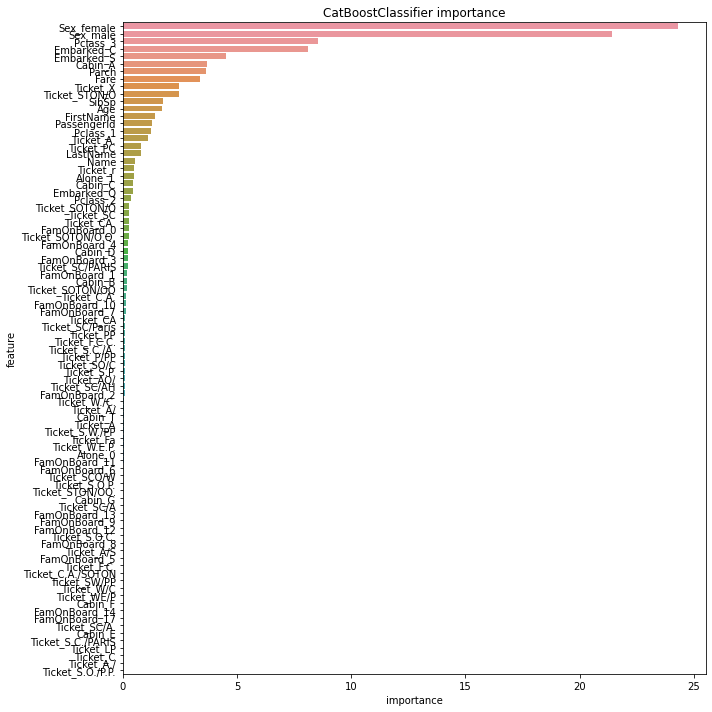

In [39]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

In [40]:
not_importante_df=feature_importances.sort_values(by='importance',ascending=False)[20:]
ctb_impotante_fut=df_final.drop(columns=list(not_importante_df.feature),axis=1)

In [41]:
# Теперь выделим тестовую часть
train_data = ctb_impotante_fut.query('sample == 1').drop(['sample'], axis=1)
test_data = ctb_impotante_fut.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Survived.values     # наш таргет
X = train_data.drop(['Survived'], axis=1)
X_sub_ctb = test_data.drop(['Survived'], axis=1)

X_train_ctb, X_test_ctb, y_train_ctb, y_test_ctb = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42)

model = CatBoostClassifier(iterations=1000,
                          depth=4,
                          #reg_lambda=0.1,
                          learning_rate=0.12,
                          eval_metric='Accuracy',
                           use_best_model=True,random_seed=42
                          )

model.fit(X_train_ctb, y_train_ctb,
          eval_set=(X_test_ctb, y_test_ctb),
          verbose_eval=100,
          #early_stopping_rounds=50,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7652000	test: 0.7668000	best: 0.7668000 (0)	total: 27.8ms	remaining: 27.8s
100:	learn: 0.7797647	test: 0.7816667	best: 0.7816667 (97)	total: 2.83s	remaining: 25.2s
200:	learn: 0.7823765	test: 0.7818667	best: 0.7826667 (196)	total: 5.63s	remaining: 22.4s
300:	learn: 0.7841647	test: 0.7827333	best: 0.7831333 (271)	total: 9.48s	remaining: 22s
400:	learn: 0.7855412	test: 0.7832667	best: 0.7837333 (365)	total: 12.2s	remaining: 18.2s
500:	learn: 0.7877059	test: 0.7832000	best: 0.7837333 (365)	total: 14.9s	remaining: 14.9s
600:	learn: 0.7893765	test: 0.7830667	best: 0.7837333 (365)	total: 18.2s	remaining: 12.1s
700:	learn: 0.7903882	test: 0.7828667	best: 0.7837333 (365)	total: 21s	remaining: 8.96s
800:	learn: 0.7917412	test: 0.7824667	best: 0.7837333 (365)	total: 23.8s	remaining: 5.92s
900:	learn: 0.7935412	test: 0.7819333	best: 0.7837333 (365)	total: 26.7s	remaining: 2.93s
999:	learn: 0.7946000	test: 0.7816667	best: 0.7837333 (365)	total: 30s	remaining: 0us

bestTest = 0.78373333

# Model 2: RandomForest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

regressor = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
predictions = regressor.predict(X_sub)

Accuracy: 0.7720666666666667


## Выделим наиболее полезные признаки и сохраним только первые 20 

In [43]:
rdf_feature_importances = pd.DataFrame()
rdf_fi_tmp = pd.DataFrame()
rdf_fi_tmp["feature"] = X_test.columns.to_list()
rdf_fi_tmp["importance"] = regressor.feature_importances_
rdf_feature_importances = rdf_feature_importances.append(rdf_fi_tmp)

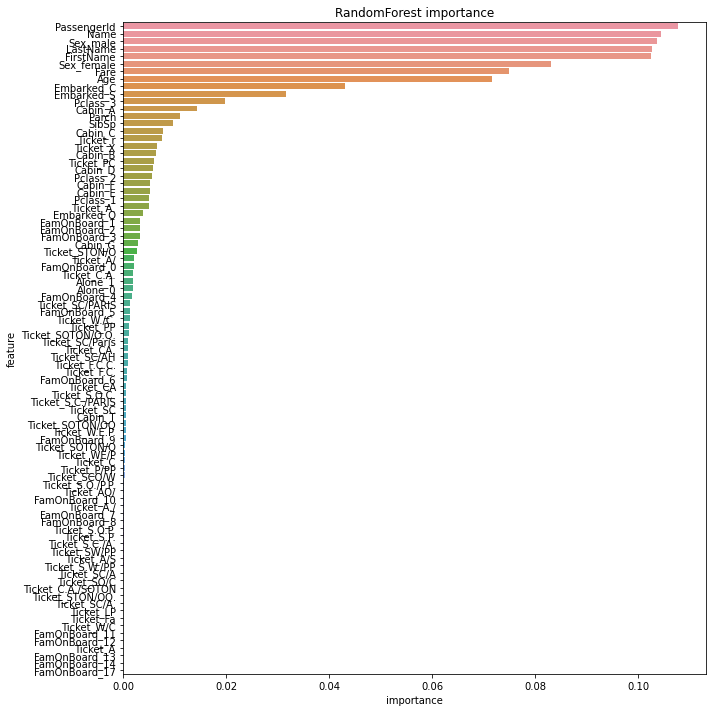

In [44]:
# just to get ideas to improve
order = list(rdf_feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=rdf_feature_importances, order=order)
plt.title("{} importance".format("RandomForest"))
plt.tight_layout()

In [45]:
not_importante_df=rdf_feature_importances.sort_values(by='importance',ascending=False)[20:]
rdf_impotante_fut=df_final.drop(columns=list(not_importante_df.feature),axis=1)

In [46]:
# Теперь выделим тестовую часть
train_data_rdf = rdf_impotante_fut.query('sample == 1').drop(['sample'], axis=1)
test_data_rdf = rdf_impotante_fut.query('sample == 0').drop(['sample'], axis=1)

y = train_data_rdf.Survived.values     # наш таргет
X = train_data_rdf.drop(['Survived'], axis=1)
X_sub_rdf = test_data_rdf.drop(['Survived'], axis=1)

X_train_rdf, X_test_rdf, y_train_rdf, y_test_rdf = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42)

regressor = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
regressor.fit(X_train_rdf, y_train_rdf)
y_pred = regressor.predict(X_test_rdf)

print("Accuracy:",metrics.accuracy_score(y_test_rdf, y_pred))
predictions = regressor.predict(X_sub_rdf)

Accuracy: 0.7708666666666667


# Model 3: LightGBM

In [47]:
train_data = df_final.query('sample == 1').drop(['sample'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(train_data.drop(['Survived'], axis=1), train_data.Survived,test_size=0.15)
feature_n = train_data.drop(columns='Survived',axis=1)
train_dataset = lgb.Dataset(X_train, Y_train, feature_name=feature_n.columns.tolist())
test_dataset = lgb.Dataset(X_test, Y_test, feature_name=feature_n.columns.tolist())

lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'acc',
        'learning_rate': 0.17,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0.13,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
    }


In [48]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, Y_train)

# predict the results
y_pred=clf.predict(X_test)
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, Y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, y_pred)))

LightGBM Model accuracy score: 0.7783


In [49]:
lgbm_feature_importances = pd.DataFrame()
lgbm_fi_tmp = pd.DataFrame()
lgbm_fi_tmp["feature"] = X_test.columns.to_list()
lgbm_fi_tmp["importance"] = clf.feature_importances_
lgbm_feature_importances = lgbm_feature_importances.append(lgbm_fi_tmp)

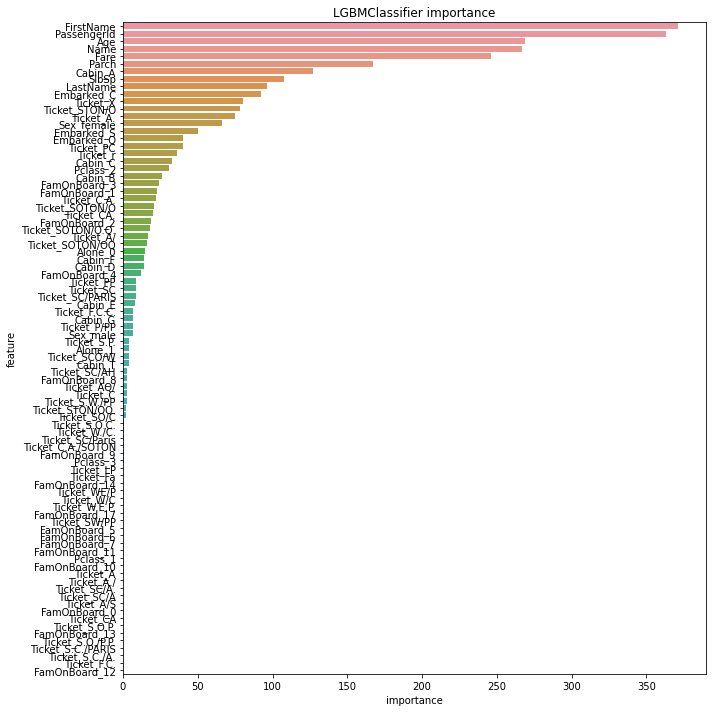

In [50]:
# just to get ideas to improve
order = list(lgbm_feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=lgbm_feature_importances, order=order)
plt.title("{} importance".format("LGBMClassifier"))
plt.tight_layout()

In [51]:
not_importante_df=lgbm_feature_importances.sort_values(by='importance',ascending=False)[20:]
lgbm_impotante_fut=df_final.drop(columns=list(not_importante_df.feature),axis=1)

In [52]:
train_data_clf = lgbm_impotante_fut.query('sample == 1').drop(['sample'], axis=1)
test_data_clf = lgbm_impotante_fut.query('sample == 0').drop(['sample'], axis=1)
X_sub_clf = test_data_clf.drop(['Survived'], axis=1)

X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(train_data_clf.drop(['Survived'], axis=1), train_data_clf.Survived,test_size=0.15)
feature_n = train_data.drop(columns='Survived',axis=1)
train_dataset = lgb.Dataset(X_train_clf, Y_train_clf, feature_name=feature_n.columns.tolist())
test_dataset = lgb.Dataset(X_test_clf, Y_test_clf, feature_name=feature_n.columns.tolist())

clf = lgb.LGBMClassifier()
clf.fit(X_train_clf, Y_train_clf)

# predict the results
y_pred_clf=clf.predict(X_test_clf)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred_clf, Y_test_clf)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test_clf, y_pred_clf)))

LightGBM Model accuracy score: 0.7798


# Model 4: Keras NN

In [322]:
# Теперь выделим тестовую часть
train_data_nn = df_final.query('sample == 1').drop(['sample'], axis=1)
test_data_nn = df_final.query('sample == 0').drop(['sample'], axis=1)

y_nn = train_data_nn.Survived.values     # наш таргет
X_nn = train_data_nn.drop(['Survived'], axis=1).values
Sub_nn = test_data_nn.drop(['Survived'], axis=1).values

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.15, shuffle=True, random_state=42)

In [323]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_nn = sc.fit_transform(X_train_nn)
X_test_nn = sc.fit_transform(X_test_nn)
#y_train_nn = sc.fit_transform(y_train_nn)
#y_test_nn = sc.fit_transform(y_test_nn)

In [324]:
model_nn = M.Sequential()
model_nn.add(L.Dense(256, activation='relu', input_dim = X_train_nn.shape[1], kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001),))
model_nn.add(L.Dense(128, activation="relu", kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001),))
model_nn.add(L.Dropout(0.5))
model_nn.add(L.Dense(1, activation='sigmoid'))


sgd = optimizers.SGD(lr = 0.008, momentum = 0.99)

model_nn.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('/kaggle/best_model_nn.hdf5', monitor=['val_accuracy'], verbose=0, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [325]:
history = model_nn.fit(X_train_nn, y_train_nn,
                    batch_size=512,
                    epochs=20,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test_nn, y_test_nn),
                    callbacks=callbacks_list,
                    verbose=2,
                    )

Epoch 1/20
167/167 - 1s - loss: 0.5418 - accuracy: 0.7365 - val_loss: 0.4935 - val_accuracy: 0.7768
Epoch 2/20
167/167 - 0s - loss: 0.4944 - accuracy: 0.7731 - val_loss: 0.4826 - val_accuracy: 0.7799
Epoch 3/20
167/167 - 0s - loss: 0.4886 - accuracy: 0.7759 - val_loss: 0.4808 - val_accuracy: 0.7815
Epoch 4/20
167/167 - 0s - loss: 0.4884 - accuracy: 0.7773 - val_loss: 0.4801 - val_accuracy: 0.7812
Epoch 5/20
167/167 - 0s - loss: 0.4846 - accuracy: 0.7780 - val_loss: 0.4793 - val_accuracy: 0.7824
Epoch 6/20
167/167 - 0s - loss: 0.4840 - accuracy: 0.7804 - val_loss: 0.4784 - val_accuracy: 0.7815
Epoch 7/20
167/167 - 1s - loss: 0.4835 - accuracy: 0.7801 - val_loss: 0.4806 - val_accuracy: 0.7815
Epoch 8/20
167/167 - 0s - loss: 0.4823 - accuracy: 0.7807 - val_loss: 0.4782 - val_accuracy: 0.7819
Epoch 9/20
167/167 - 0s - loss: 0.4819 - accuracy: 0.7795 - val_loss: 0.4803 - val_accuracy: 0.7814
Epoch 10/20
167/167 - 0s - loss: 0.4806 - accuracy: 0.7800 - val_loss: 0.4789 - val_accuracy: 0.7801

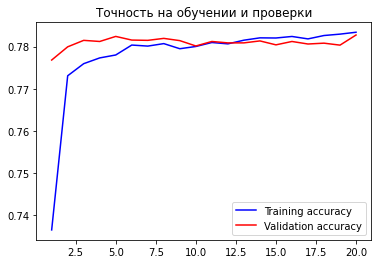

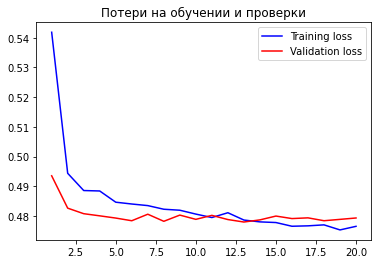

In [326]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

# Ансамблируем модели

In [328]:
predictions_cat_0 = model.predict(X_test_ctb)
predictions_rdf_0 = regressor.predict(X_test_rdf)
predictions_lgb_0 = clf.predict(X_test_clf)
prediction_keras_nn = model_nn.predict(X_test_nn)
prediction_keras_nn = prediction_keras_nn[prediction_keras_nn>0]

result_0=(predictions_cat_0+predictions_rdf_0+predictions_lgb_0+prediction_keras_nn)/4
result_0 = np.around(result_0).astype(int)

print('All Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, result_0)))

All Model accuracy score: 0.7777


In [329]:
predictions_cat = model.predict(X_sub)
predictions_rdf = regressor.predict(X_sub_rdf)
predictions_lgb = clf.predict(X_sub_clf)
prediction_keras = model_nn.predict(Sub_nn)
prediction_keras = prediction_keras_nn[prediction_keras_nn>0]

In [330]:
result = (predictions_cat+predictions_rdf+predictions_lgb+prediction_keras)/4
result = np.around(result).astype(int)

ValueError: operands could not be broadcast together with shapes (100000,) (15000,) 

In [56]:
my_submission = pd.DataFrame({'PassengerId': df_test.PassengerId ,
                              'Survived': (result.astype(int)) })

my_submission.to_csv("submission.csv",index=False)

In [57]:
my_submission

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1
